# Pytorch Long-Short Term Memory (LSTM) Neural Network Practice Example

## Started May 28, 2019
### Genevieve Hayes

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sb
import matplotlib.pylab as plt
#import matplotlib as mpl
import h5py
import tables
import math
import time
import sklearn.metrics as sklm

# Try Generating Data to explore LSTM inputs

In [104]:
from sklearn.model_selection import train_test_split

class TimeSeriesData:
    def __init__(self, num_datapoints, test_size=0.2, max_t=20, num_prev=1,
                 noise_var=1):
        """
        Template class for generating time series data.
        :param test_size: in (0,1), data to be used in test set as a fraction of all data generated.
        """
        self.num_datapoints = num_datapoints
        self.test_size = test_size
        self.num_prev = num_prev
        self.max_t = max_t
        self.data = None
        self.noise_var = noise_var
        self.y = np.zeros(num_datapoints + num_prev*4) # TODO: check this
        self.bayes_preds = np.copy(self.y)

        # Generate data and reshape data
        self.create_data()

        # Split into training and test sets
        self.train_test_split()

    def create_data(self):
        self.generate_data()
        self.reshape_data()

    def generate_data(self):
        """Generates data in self.y, may take as implicit input timesteps self.t.
        May also generate Bayes predictions."""
        raise NotImplementedError("Generate data method not implemented.")

    def reshape_data(self):
        self.x = np.reshape([self.y[i:i + self.num_prev] for i in range(
            self.num_datapoints)], (-1, self.num_prev))
        self.y = np.copy(self.y[self.num_prev:])
        self.bayes_preds = np.copy(self.bayes_preds[self.num_prev:])

    def train_test_split(self):
        test_size = int(len(self.y) * self.test_size)
        self.data = [self.X_train, self.X_test, self.y_train,
                     self.y_test] = \
                    self.x[:-test_size], self.x[-test_size:], \
                    self.y[:-test_size], self.y[-test_size:]
        self.bayes_preds = [self.bayes_train_preds, self.bayes_test_preds] = self.bayes_preds[:-test_size], self.bayes_preds[-test_size:]

    def return_data(self):
        return self.data

    def return_train_test(self):
        return self.X_train, self.y_train, self.X_test, self.y_test

class ARData(TimeSeriesData):
    """Class to generate autoregressive data."""

    def __init__(self, *args, coeffs=None, **kwargs):
        self.given_coeffs = coeffs
        super(ARData, self).__init__(*args, **kwargs)

        if coeffs is not None:
            self.num_prev = len(coeffs) - 1

    def generate_data(self):
        self.generate_coefficients()
        self.generate_initial_points()

        # + 3*self.num_prev because we want to cut first (3*self.num_prev) datapoints later
        # so dist is more stationary (else initial num_prev datapoints will stand out as diff dist)
        for i in range(self.num_datapoints+3*self.num_prev):
            # Generate y value if there was no noise
            # (equivalent to Bayes predictions: predictions from oracle that knows true parameters (coefficients))
            self.bayes_preds[i + self.num_prev] = np.dot(self.y[i:self.num_prev+i][::-1], self.coeffs)
            # Add noise
            self.y[i + self.num_prev] = self.bayes_preds[i + self.num_prev] + self.noise()

        # Cut first 20 points so dist is roughly stationary
        self.bayes_preds = self.bayes_preds[3*self.num_prev:]
        self.y = self.y[3*self.num_prev:]

    def generate_coefficients(self):
        if self.given_coeffs is not None:
            self.coeffs = self.given_coeffs
        else:
            filter_stable = False
            # Keep generating coefficients until we come across a set of coefficients
            # that correspond to stable poles
            while not filter_stable:
                true_theta = np.random.random(self.num_prev) - 0.5
                coefficients = np.append(1, -true_theta)
                # check if magnitude of all poles is less than one
                if np.max(np.abs(np.roots(coefficients))) < 1:
                    filter_stable = True
            self.coeffs = true_theta

    def generate_initial_points(self):
        # Initial datapoints distributed as N(0,1)
        self.y[:self.num_prev] = np.random.randn(self.num_prev)

    def noise(self):
        # Noise distributed as N(0, self.noise_var)
        return self.noise_var * np.random.randn()


In [120]:
#####################
# Set parameters
#####################


BATCH_SIZE = 20

# Data params
noise_var = 0
num_datapoints = 100
test_size = 0.2


num_train = int((1-test_size)*num_datapoints)

# Network params
input_size = 8
# If `per_element` is True, then LSTM reads in one timestep at a time.
per_element = True
if per_element:
    lstm_input_size = 1
else:
    lstm_input_size = input_size
# size of hidden layers
h1 = 32
output_dim = 1
num_layers = 2
learning_rate = 1e-3
num_epochs = 500
dtype = torch.float

#####################
# Generate data
#####################
data = ARData(num_datapoints, num_prev=input_size, test_size=test_size, noise_var=noise_var)

# make training and test sets in torch
X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
X_test = torch.from_numpy(data.X_test).type(torch.Tensor)
y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)

X_train = X_train.view([input_size, -1, 1])
X_test = X_test.view([input_size, -1, 1])

# Build Network Structure

In [121]:
#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        #lstm_out, self.hidden = self.lstm(input.view(input.size(), self.batch_size, -1))  
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)

model = LSTM(lstm_input_size, h1, batch_size=BATCH_SIZE, output_dim=output_dim, num_layers=num_layers)

# Define Loss function and Optimizer

In [122]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [123]:
print(X_train.size())
print(y_train.size())
print(y_pred.size())

print(num_train)
print(X_train[1,:].size())
print(len(X_train))

# def batch(iterable, n=1):
#     l = len(iterable)
#     for ndx in range(0,l,n):
#         yield iterable[ndx:min(ndx + n, l)]
        
# for x in batch(X_train, num_train):
#     print(len(x))
    
# X_train == x

torch.Size([8, 80, 1])
torch.Size([80])
torch.Size([80])
80
torch.Size([80, 1])
8


# Train model

In [124]:
#####################
# Train model
#####################

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model(X_train)

    loss = loss_fn(y_pred, y_train)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

RuntimeError: input.size(-1) must be equal to input_size. Expected 1, got 4

# Evaluate Performance

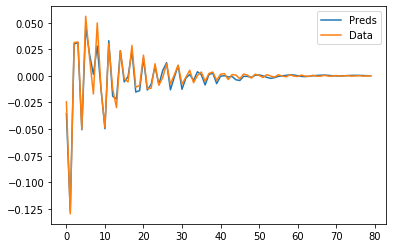

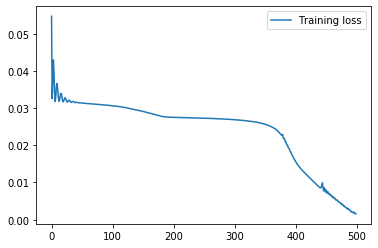

In [119]:
#####################
# Plot preds and performance
#####################

plt.plot(y_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

# Other code that I'm emotionally attached to 

In [96]:
#####################
#Gregor Dataset
#####################

# from torch.autograd import Variable
# from torch.utils.data import Dataset, DataLoader, random_split

# # Training dataset loading class
# class TrainDataset(Dataset):
#     # Initialize our data, download, etc.  
#     def __init__(self):
#         #open hdf5 file for reading
#         hdf_train = pd.HDFStore('train.h5',mode='r')
#         hdf_train.keys()
#         table_train = hdf_train.get('/table')
        
#         #numpy representation of DataFrame
#         array_train = table_train.values
        
#         self.len = array_train.shape[0]
#         self.x_data = torch.from_numpy(array_train[:,0:800]).float() #x data is only the 4 vectors of the constituents 
#         self.y_data = torch.from_numpy(array_train[:,-1]).long() #y data is only the labels (0=QCD, 1=top)
        
#     def __getitem__(self,index):
#         return self.x_data[index],self.y_data[index]
    
#     def __len__(self):
#         return self.len
    
# # Validation dataset loading class
# class ValDataset(Dataset):
#     # Initialize our data, download, etc.
#     def __init__(self):
#         #open hdf5 file for reading
#         hdf_val = pd.HDFStore('val.h5',mode='r')
#         hdf_val.keys()
#         table_val = hdf_val.get('/table')
        
#         #numpy representation of DataFrame
#         array_val = table_val.values
        
#         self.len = array_val.shape[0]
#         self.x_data = torch.from_numpy(array_val[:,0:800]).float()
#         self.y_data = torch.from_numpy(array_val[:,-1]).long()
        
#     def __getitem__(self,index):
#         return self.x_data[index],self.y_data[index]
    
#     def __len__(self):
#         return self.len



# training_dataset = TrainDataset()
# validation_dataset = ValDataset()

# train_len = training_dataset.len
# val_len = validation_dataset.len

In [125]:
##########################################
##########################################
##########################################
#train MNIST LSTM that MAKES SENSE

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        #Load images as torch tensor with gradient accumulation abilities
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        
        #Clear gradients with respect to parameters
        optimizer.zero_grad()
        
        #Forward pass to get output/logits
        #outputs.size() --> 100,10
        outputs = model(images)
        
        #Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs,labels)
        #Getting gradients with respect to parameters
        loss.backward()
        #Updating parameters
        optimizer.step()
        
        #Store the training loss and # of corrects and total number of events
        train_loss += loss.item()*images.size(0)   
        total = labels.size(0)
        
        #extract TP+TN
        train_corrects += torch.sum(preds == labels.data)
        
    #epoch_loss = train_loss/train_len
    #epoch_acc = train_corrects/train_len
    
    print(train_loss/train_len)
        
        
        
        

SyntaxError: unexpected EOF while parsing (<ipython-input-125-441934c9ea55>, line 4)

In [191]:
# #######################
# # Build Model
# #######################

# class LSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2):
#         super(LSTM, self).__init__()
        
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.batch_size = batch_size
#         self.num_layers = num_layers
        
#         #Define the LSTM layer
#         self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        
#         #Define the output layer
#         self.linear = nn.Linear(self.hidden_dim, output_dim)
        
#     #initialize hidden states
#     def init_hidden(self):
#          return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim) \
#                     ,torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        
#     def forward(self, input):
#         # Forward pass through LSTM layer
#         # shape of lstm_out: [input_size, batch_size, hidden_dim]
#         # shape of self.hidden: (a, b), where a and b both have shape (num_layers,batch_size, hidden_dim)
        
#         #lstm_out, self.hidden = self.lstm(input.view(len(input),self.batch_size, -1))
#         #lstm_out, self.hidden = self.lstm(input.view(input[1,:].size()),self.batch_size, -1)
#         lstm_out, self.hidden = self.lstm(input.view(input[0,:].size()),self.batch_size, -1)
#         #lstm_out, self.hidden = self.lstm(input.view(input[1,:].size(),self.batch_size))
        
#         #Only take the output from the final timestep
#         #If seq2seq prediction, can pass on the entirety of lstm_out to the next layer
#         y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
#         return y_pred.view(-1)
#         y_pred = self.linear(lstm_out[-1].view(self.batch_size))
#         #return y_pred
        
# model = LSTM(lstm_input_size, h1, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)    
        

# Define Loss function and Optimizer

In [192]:
# loss_function = torch.nn.MSELoss(size_average=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)